# AIxSuture Dataset Preprocessing - OSS Challenge 2025

**Dataset Description:**
- 314 videos (5 minutes each) from 157 students
- Pre/Post training evaluation (before and after 1-hour course)
- 3 experienced raters (inter-rater reliability: 0.8-0.83)
- OSATS assessment with 8 criteria + Global Rating Score
- Blinded and anonymized evaluation

**Processing Pipeline:**
1. Load multi-rater OSATS data (3 raters per video)
2. Aggregate ratings using optimal strategy
3. Extract frames at 5 fps for TimeSformer
4. Create 16-frame sequences with overlap
5. Prepare train/validation splits

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(2025)
np.random.seed(2025)

## 1. Configuration

In [2]:
CONFIG = {
    'dataset_path': '../dataset/',
    'videos_path': '../dataset/videos/',
    'osats_file': '../dataset/OSATS.csv',
    'output_path': '../processed_data/',
    'fps': 5,
    'frame_size': (224, 224),
    'sequence_length': 16,
    'overlap': 8,
    'imagenet_mean': [0.485, 0.456, 0.406],
    'imagenet_std': [0.229, 0.224, 0.225],
    'aggregation_strategy': 'average',
    'use_pre_post_split': True,
    'include_suture_count': True
}

GRS_MAPPING = {
    'ranges': [(8, 15), (16, 23), (24, 31), (32, 40)],
    'labels': ['Novice', 'Intermediate', 'Proficient', 'Expert'],
    'classes': [0, 1, 2, 3]
}

os.makedirs(CONFIG['output_path'], exist_ok=True)
os.makedirs(os.path.join(CONFIG['output_path'], 'frames'), exist_ok=True)

## 2. Load AIxSuture OSATS Data

In [3]:
def load_aixsuture_data():
    osats_file = CONFIG['osats_file']
    
    if os.path.exists(osats_file):
        if osats_file.endswith('.csv'):
            df = pd.read_csv(osats_file)
        else:
            df = pd.read_excel(osats_file)
        print(f"Loaded OSATS data from {osats_file}")
    else:
        excel_file = osats_file.replace('.csv', '.xlsx')
        if os.path.exists(excel_file):
            df = pd.read_excel(excel_file)
            print(f"Loaded OSATS data from {excel_file}")
        else:
            print(f"Creating AIxSuture sample data...")
            return create_aixsuture_sample()
    
    df.columns = df.columns.str.strip().str.upper()
    
    column_mapping = {
        'VIDEO': 'video_name',
        'INVESTIGATOR': 'investigator',
        'STUDENT': 'student_id',
        'TIME': 'session',
        'SUTURES': 'suture_count',
        'GLOBA_RATING_SCORE': 'grs_total',
        'GLOBAL_RATING_SCORE': 'grs_total',
        'OSATS_RESPECT': 'RESPECT',
        'OSATS_MOTION': 'MOTION',
        'OSATS_INSTRUMENT': 'INSTRUMENT',
        'OSATS_SUTURE': 'SUTURE',
        'OSATS_FLOW': 'FLOW',
        'OSATS_KNOWLEDGE': 'KNOWLEDGE',
        'OSATS_PERFORMANCE': 'PERFORMANCE',
        'OSATS_FINAL_QUALITY': 'FINALQUALITY'
    }
    
    df = df.rename(columns=column_mapping)
    df['video_file'] = df['video_name'].apply(lambda x: f"{x}.mp4")
    
    return df

def create_aixsuture_sample():
    print("Creating AIxSuture sample data (314 videos, 157 students, 3 raters)...")
    
    np.random.seed(2025)
    sample_data = []
    investigators = ['A', 'B', 'C']
    sessions = ['PRE', 'POST']
    
    for student_id in range(1, 158):
        for session in sessions:
            video_name = f"S{student_id:03d}_{session}"
            
            if session == 'PRE':
                base_skill = np.random.choice([0, 1, 2], p=[0.5, 0.4, 0.1])
            else:
                base_skill = np.random.choice([1, 2, 3], p=[0.3, 0.5, 0.2])
            
            if base_skill == 0:
                base_scores = np.random.randint(1, 3, 8)
                base_grs = np.random.randint(8, 16)
                suture_count = np.random.randint(1, 4)
            elif base_skill == 1:
                base_scores = np.random.randint(2, 4, 8)
                base_grs = np.random.randint(16, 24)
                suture_count = np.random.randint(2, 6)
            elif base_skill == 2:
                base_scores = np.random.randint(3, 5, 8)
                base_grs = np.random.randint(24, 32)
                suture_count = np.random.randint(4, 8)
            else:
                base_scores = np.random.randint(4, 6, 8)
                base_grs = np.random.randint(32, 41)
                suture_count = np.random.randint(6, 12)
            
            for inv in investigators:
                if inv == 'A':
                    variation = np.random.randint(-1, 1, 8)
                    grs_variation = np.random.randint(-2, 1)
                elif inv == 'B':
                    variation = np.random.randint(-1, 2, 8)
                    grs_variation = np.random.randint(-1, 2)
                else:
                    variation = np.random.randint(0, 2, 8)
                    grs_variation = np.random.randint(0, 3)
                
                scores = np.clip(base_scores + variation, 1, 5)
                grs = np.clip(base_grs + grs_variation, 8, 40)
                
                sample_data.append({
                    'student_id': f'STU{student_id:03d}',
                    'session': session,
                    'suture_count': suture_count,
                    'investigator': inv,
                    'video_name': video_name,
                    'video_file': f'{video_name}.mp4',
                    'RESPECT': scores[0],
                    'MOTION': scores[1],
                    'INSTRUMENT': scores[2],
                    'SUTURE': scores[3],
                    'FLOW': scores[4],
                    'KNOWLEDGE': scores[5],
                    'PERFORMANCE': scores[6],
                    'FINALQUALITY': scores[7],
                    'grs_total': grs
                })
    
    return pd.DataFrame(sample_data)

raw_osats_df = load_aixsuture_data()

print(f"\nAIxSuture Dataset Analysis:")
print(f"Total entries: {len(raw_osats_df)}")
print(f"Unique videos: {raw_osats_df['video_name'].nunique()}")
print(f"Unique students: {raw_osats_df['student_id'].nunique()}")
print(f"Sessions: {sorted(raw_osats_df['session'].unique())}")
print(f"Investigators: {sorted(raw_osats_df['investigator'].unique())}")
print(f"Expected structure: {len(raw_osats_df)} = {raw_osats_df['video_name'].nunique()} videos × 3 raters")

session_counts = raw_osats_df.groupby('session')['video_name'].nunique()
print(f"\nVideos per session:")
for session, count in session_counts.items():
    print(f"  {session}: {count} videos")

Loaded OSATS data from ../dataset/OSATS.xlsx

AIxSuture Dataset Analysis:
Total entries: 942
Unique videos: 314
Unique students: 157
Sessions: ['POST', 'PRE']
Investigators: ['A', 'B', 'C']
Expected structure: 942 = 314 videos × 3 raters

Videos per session:
  POST: 157 videos
  PRE: 157 videos


## 3. Inter-Rater Reliability Analysis


=== INTER-RATER RELIABILITY ANALYSIS ===

GRS Inter-Rater Reliability:
  Mean std across videos: 3.314
  Median std across videos: 3.300
  Videos with std ≤ 1: 19/314 (6.1%)
  Videos with std ≤ 2: 55/314 (17.5%)

Inter-rater correlations (GRS):
  A vs B: 0.802
  A vs C: 0.832
  B vs C: 0.815
  Mean inter-rater correlation: 0.816


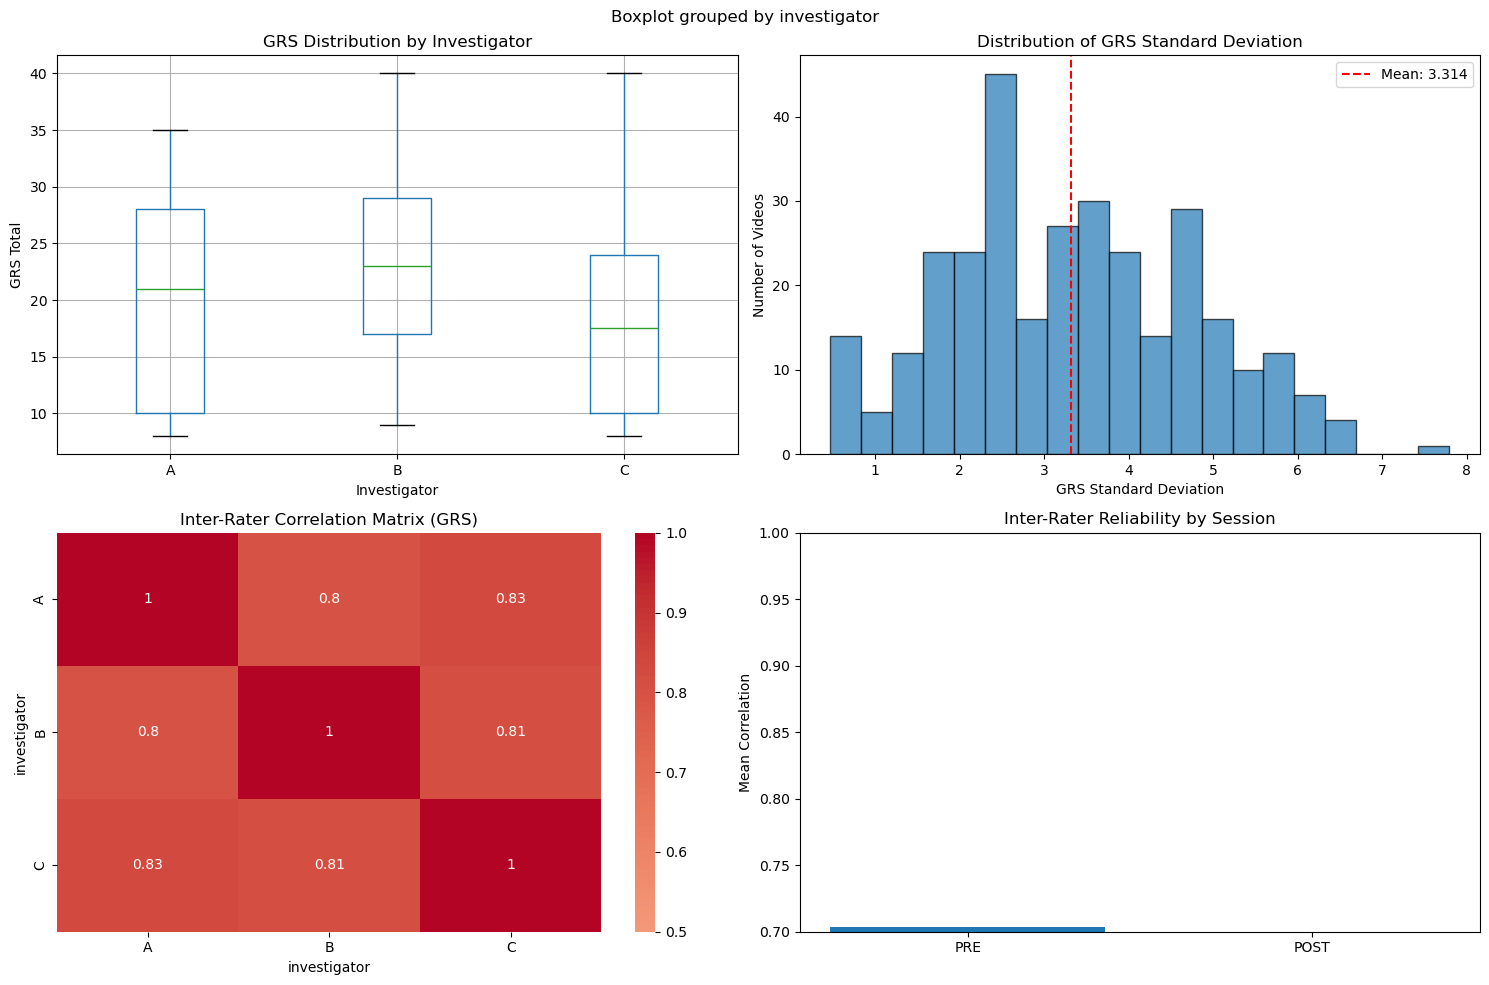

In [4]:
def analyze_inter_rater_reliability(df):
    print(f"\n=== INTER-RATER RELIABILITY ANALYSIS ===")
    
    osats_columns = ['RESPECT', 'MOTION', 'INSTRUMENT', 'SUTURE',
                    'FLOW', 'KNOWLEDGE', 'PERFORMANCE', 'FINALQUALITY']
    
    video_stats = []
    
    for video_name in df['video_name'].unique():
        video_data = df[df['video_name'] == video_name]
        
        stats = {'video_name': video_name}
        
        grs_scores = video_data['grs_total'].values
        stats['grs_mean'] = np.mean(grs_scores)
        stats['grs_std'] = np.std(grs_scores)
        stats['grs_range'] = np.max(grs_scores) - np.min(grs_scores)
        
        for col in osats_columns:
            if col in video_data.columns:
                values = video_data[col].values
                stats[f'{col}_mean'] = np.mean(values)
                stats[f'{col}_std'] = np.std(values)
        
        video_stats.append(stats)
    
    stats_df = pd.DataFrame(video_stats)
    
    print(f"\nGRS Inter-Rater Reliability:")
    print(f"  Mean std across videos: {stats_df['grs_std'].mean():.3f}")
    print(f"  Median std across videos: {stats_df['grs_std'].median():.3f}")
    print(f"  Videos with std ≤ 1: {(stats_df['grs_std'] <= 1).sum()}/{len(stats_df)} ({(stats_df['grs_std'] <= 1).mean()*100:.1f}%)")
    print(f"  Videos with std ≤ 2: {(stats_df['grs_std'] <= 2).sum()}/{len(stats_df)} ({(stats_df['grs_std'] <= 2).mean()*100:.1f}%)")
    
    grs_pivot = df.pivot_table(index='video_name', columns='investigator', values='grs_total', aggfunc='mean')
    correlations = grs_pivot.corr()
    
    print(f"\nInter-rater correlations (GRS):")
    for i, inv1 in enumerate(correlations.index):
        for j, inv2 in enumerate(correlations.columns):
            if i < j:
                corr = correlations.loc[inv1, inv2]
                print(f"  {inv1} vs {inv2}: {corr:.3f}")
    
    mean_correlation = correlations.values[np.triu_indices_from(correlations.values, k=1)].mean()
    print(f"  Mean inter-rater correlation: {mean_correlation:.3f}")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    df.boxplot(column='grs_total', by='investigator', ax=axes[0,0])
    axes[0,0].set_title('GRS Distribution by Investigator')
    axes[0,0].set_xlabel('Investigator')
    axes[0,0].set_ylabel('GRS Total')
    
    axes[0,1].hist(stats_df['grs_std'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Distribution of GRS Standard Deviation')
    axes[0,1].set_xlabel('GRS Standard Deviation')
    axes[0,1].set_ylabel('Number of Videos')
    axes[0,1].axvline(stats_df['grs_std'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {stats_df["grs_std"].mean():.3f}')
    axes[0,1].legend()
    
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, ax=axes[1,0],
                vmin=0.5, vmax=1.0)
    axes[1,0].set_title('Inter-Rater Correlation Matrix (GRS)')
    
    session_reliability = []
    for session in df['session'].unique():
        session_data = df[df['session'] == session]
        session_pivot = session_data.pivot_table(index='video_name', columns='investigator', 
                                                values='grs_total', aggfunc='mean')
        session_corr = session_pivot.corr().values[np.triu_indices_from(session_pivot.corr().values, k=1)].mean()
        session_reliability.append({'Session': session, 'Mean_Correlation': session_corr})
    
    session_rel_df = pd.DataFrame(session_reliability)
    axes[1,1].bar(session_rel_df['Session'], session_rel_df['Mean_Correlation'])
    axes[1,1].set_title('Inter-Rater Reliability by Session')
    axes[1,1].set_ylabel('Mean Correlation')
    axes[1,1].set_ylim(0.7, 1.0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_path'], 'inter_rater_analysis.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return stats_df

reliability_stats = analyze_inter_rater_reliability(raw_osats_df)

## 4. Multi-Rater Score Aggregation

In [5]:
def aggregate_multi_rater_scores(df, strategy='average'):
    print(f"\n=== AGGREGATING SCORES USING '{strategy.upper()}' STRATEGY ===")
    
    osats_columns = ['RESPECT', 'MOTION', 'INSTRUMENT', 'SUTURE',
                    'FLOW', 'KNOWLEDGE', 'PERFORMANCE', 'FINALQUALITY']
    
    aggregated_data = []
    
    for video_name in df['video_name'].unique():
        video_data = df[df['video_name'] == video_name]
        base_info = video_data.iloc[0].to_dict()
        
        if strategy == 'average':
            aggregated_scores = {
                'grs_total': video_data['grs_total'].mean(),
                'grs_std': video_data['grs_total'].std(),
                'suture_count': video_data['suture_count'].iloc[0] if 'suture_count' in video_data.columns else None
            }
            
            for col in osats_columns:
                if col in video_data.columns:
                    aggregated_scores[col] = video_data[col].mean()
                    aggregated_scores[f'{col}_std'] = video_data[col].std()
        
        elif strategy == 'median':
            aggregated_scores = {
                'grs_total': video_data['grs_total'].median(),
                'grs_std': video_data['grs_total'].std(),
                'suture_count': video_data['suture_count'].iloc[0] if 'suture_count' in video_data.columns else None
            }
            
            for col in osats_columns:
                if col in video_data.columns:
                    aggregated_scores[col] = video_data[col].median()
                    aggregated_scores[f'{col}_std'] = video_data[col].std()
        
        final_entry = {
            'video_name': video_name,
            'video_file': base_info['video_file'],
            'student_id': base_info['student_id'],
            'session': base_info['session'],
            'aggregation_strategy': strategy,
            **aggregated_scores
        }
        
        aggregated_data.append(final_entry)
    
    aggregated_df = pd.DataFrame(aggregated_data)
    
    print(f"Aggregation Results:")
    print(f"  Original entries: {len(df)}")
    print(f"  Unique videos: {df['video_name'].nunique()}")
    print(f"  Aggregated entries: {len(aggregated_df)}")
    
    return aggregated_df

def map_grs_to_class(grs_score):
    if 8 <= grs_score <= 15:
        return 0
    elif 16 <= grs_score <= 23:
        return 1
    elif 24 <= grs_score <= 31:
        return 2
    elif 32 <= grs_score <= 40:
        return 3
    else:
        return -1

osats_df = aggregate_multi_rater_scores(raw_osats_df, CONFIG['aggregation_strategy'])

osats_df['grs_class'] = osats_df['grs_total'].apply(map_grs_to_class)
valid_entries = osats_df['grs_class'] >= 0
osats_df = osats_df[valid_entries].reset_index(drop=True)

osats_df['grs_label'] = osats_df['grs_class'].apply(
    lambda x: GRS_MAPPING['labels'][x] if x >= 0 else 'Invalid'
)

print(f"\nFinal Dataset Summary:")
print(f"Total videos: {len(osats_df)}")
print(f"Students: {osats_df['student_id'].nunique()}")
print(f"\nClass distribution:")
print(osats_df['grs_label'].value_counts())

print(f"\nSession distribution:")
session_class_dist = pd.crosstab(osats_df['session'], osats_df['grs_label'])
print(session_class_dist)

if 'suture_count' in osats_df.columns:
    print(f"\nSuture count statistics:")
    print(osats_df['suture_count'].describe())
    
    suture_by_class = osats_df.groupby('grs_label')['suture_count'].mean()
    print(f"\nMean sutures by skill level:")
    for label, count in suture_by_class.items():
        print(f"  {label}: {count:.1f} sutures")


=== AGGREGATING SCORES USING 'AVERAGE' STRATEGY ===
Aggregation Results:
  Original entries: 942
  Unique videos: 314
  Aggregated entries: 314

Final Dataset Summary:
Total videos: 290
Students: 157

Class distribution:
grs_label
Novice          110
Proficient      102
Intermediate     60
Expert           18
Name: count, dtype: int64

Session distribution:
grs_label  Expert  Intermediate  Novice  Proficient
session                                            
POST           17            26       2          96
PRE             1            34     108           6

Suture count statistics:
count    290.000000
mean       3.122414
std        1.857282
min        0.500000
25%        1.500000
50%        3.500000
75%        4.500000
max        8.000000
Name: suture_count, dtype: float64

Mean sutures by skill level:
  Expert: 5.5 sutures
  Intermediate: 3.4 sutures
  Novice: 1.3 sutures
  Proficient: 4.5 sutures


## 5. Video Discovery and Matching

In [6]:
def discover_and_match_videos():
    videos_path = Path(CONFIG['videos_path'])
    
    if not videos_path.exists():
        print(f"Videos directory not found: {videos_path}")
        print(f"Creating simulated video info for {len(osats_df)} videos...")
        return create_simulated_video_info()
    
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    video_files = []
    
    for ext in video_extensions:
        video_files.extend(list(videos_path.glob(f'*{ext}')))
    
    print(f"\nFound {len(video_files)} video files in {videos_path}")
    
    matched_videos = []
    missing_videos = []
    
    for idx, row in osats_df.iterrows():
        video_file = row['video_file']
        video_path = videos_path / video_file
        
        if video_path.exists():
            matched_videos.append({
                'video_name': row['video_name'],
                'video_file': video_file,
                'video_path': str(video_path),
                'student_id': row['student_id'],
                'session': row['session'],
                'grs_class': row['grs_class'],
                'grs_total': row['grs_total'],
                'grs_std': row.get('grs_std', 0),
                'suture_count': row.get('suture_count', None),
                'osats_data': row.to_dict()
            })
        else:
            missing_videos.append(video_file)
    
    print(f"\nVideo Matching Results:")
    print(f"  Matched videos: {len(matched_videos)}")
    print(f"  Missing videos: {len(missing_videos)}")
    
    if missing_videos:
        print(f"\nFirst 10 missing videos: {missing_videos[:10]}")
    
    return matched_videos

def create_simulated_video_info():
    simulated_videos = []
    
    for idx, row in osats_df.iterrows():
        simulated_videos.append({
            'video_name': row['video_name'],
            'video_file': row['video_file'],
            'video_path': f"simulated/{row['video_file']}",
            'student_id': row['student_id'],
            'session': row['session'],
            'grs_class': row['grs_class'],
            'grs_total': row['grs_total'],
            'grs_std': row.get('grs_std', 0),
            'suture_count': row.get('suture_count', None),
            'osats_data': row.to_dict(),
            'simulated': True,
            'duration': 300.0,
            'frames_count': 1500
        })
    
    print(f"Created simulated info for {len(simulated_videos)} videos")
    return simulated_videos

matched_videos = discover_and_match_videos()

print(f"\nFinal Matched Dataset:")
print(f"  Total videos: {len(matched_videos)}")
print(f"  Students: {len(set(v['student_id'] for v in matched_videos))}")

session_counts = Counter(v['session'] for v in matched_videos)
print(f"  Session distribution: {dict(session_counts)}")

class_counts = Counter(v['grs_class'] for v in matched_videos)
print(f"\nClass distribution in matched videos:")
for class_id in sorted(class_counts.keys()):
    class_name = GRS_MAPPING['labels'][class_id]
    print(f"  Class {class_id} ({class_name}): {class_counts[class_id]} videos")


Found 30 video files in ../dataset/videos

Video Matching Results:
  Matched videos: 28
  Missing videos: 262

First 10 missing videos: ['P54M.mp4', 'D44W.mp4', 'W44D.mp4', 'V34K.mp4', 'K43V.mp4', 'V16A.mp4', 'S84F.mp4', 'V63F.mp4', 'F36V.mp4', 'N75S.mp4']

Final Matched Dataset:
  Total videos: 28
  Students: 28
  Session distribution: {'POST': 10, 'PRE': 18}

Class distribution in matched videos:
  Class 0 (Novice): 12 videos
  Class 1 (Intermediate): 5 videos
  Class 2 (Proficient): 8 videos
  Class 3 (Expert): 3 videos


## 6. Frame Extraction

In [7]:
def extract_frames_from_video(video_info, output_dir, fps=5, frame_size=(224, 224)):
    video_name = video_info['video_name']
    video_path = video_info['video_path']
    
    if video_info.get('simulated', False):
        return create_simulated_frames(video_info, fps)
    
    frame_dir = os.path.join(output_dir, video_name)
    os.makedirs(frame_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return []
    
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / original_fps
    
    frame_interval = max(1, int(original_fps / fps))
    
    extracted_frames = []
    frame_count = 0
    saved_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % frame_interval == 0:
            resized_frame = cv2.resize(frame, frame_size)
            
            frame_filename = f"frame_{saved_count:06d}.jpg"
            frame_path = os.path.join(frame_dir, frame_filename)
            
            cv2.imwrite(frame_path, resized_frame)
            
            extracted_frames.append({
                'path': frame_path,
                'frame_number': saved_count,
                'timestamp': frame_count / original_fps
            })
            
            saved_count += 1
        
        frame_count += 1
    
    cap.release()
    return extracted_frames

def create_simulated_frames(video_info, fps):
    duration = video_info.get('duration', 300.0)
    num_frames = int(duration * fps)
    
    frames = []
    for i in range(num_frames):
        frames.append({
            'path': f"simulated/{video_info['video_name']}/frame_{i:06d}.jpg",
            'frame_number': i,
            'timestamp': i / fps,
            'simulated': True
        })
    
    return frames

def process_all_videos():
    processed_videos = []
    frames_output_dir = os.path.join(CONFIG['output_path'], 'frames')
    
    print(f"\nProcessing {len(matched_videos)} videos...")
    
    for video_info in tqdm(matched_videos, desc="Extracting frames"):
        try:
            frames = extract_frames_from_video(
                video_info,
                frames_output_dir,
                fps=CONFIG['fps'],
                frame_size=CONFIG['frame_size']
            )
            
            processed_videos.append({
                **video_info,
                'frames_extracted': len(frames),
                'frames_info': frames,
                'status': 'success'
            })
            
        except Exception as e:
            print(f"Error processing {video_info['video_name']}: {str(e)}")
            processed_videos.append({
                **video_info,
                'frames_extracted': 0,
                'frames_info': [],
                'status': f'error: {str(e)}'
            })
    
    return processed_videos

processed_videos = process_all_videos()

successful_videos = [v for v in processed_videos if v['status'] == 'success']
failed_videos = [v for v in processed_videos if v['status'] != 'success']

print(f"\nFrame Extraction Results:")
print(f"  Successful: {len(successful_videos)}")
print(f"  Failed: {len(failed_videos)}")

if successful_videos:
    total_frames = sum(v['frames_extracted'] for v in successful_videos)
    avg_frames = total_frames / len(successful_videos)
    print(f"  Total frames extracted: {total_frames:,}")
    print(f"  Average frames per video: {avg_frames:.1f}")
    print(f"  Expected frames per 5-min video: {5 * 60 * CONFIG['fps']} frames")


Processing 28 videos...


Extracting frames: 100%|██████████| 28/28 [10:38<00:00, 22.80s/it]


Frame Extraction Results:
  Successful: 28
  Failed: 0
  Total frames extracted: 51,275
  Average frames per video: 1831.2
  Expected frames per 5-min video: 1500 frames


## 7. Create Training Sequences

In [8]:
def create_sequences_from_frames(frames_info, sequence_length=16, overlap=8):
    sequences = []
    
    if len(frames_info) < sequence_length:
        extended_frames = frames_info * (sequence_length // len(frames_info) + 1)
        sequences.append(extended_frames[:sequence_length])
    else:
        step = sequence_length - overlap
        for i in range(0, len(frames_info) - sequence_length + 1, step):
            sequence = frames_info[i:i + sequence_length]
            sequences.append(sequence)
    
    return sequences

def prepare_training_data():
    training_data = []
    
    for video_info in processed_videos:
        if video_info['status'] != 'success':
            continue
        
        sequences = create_sequences_from_frames(
            video_info['frames_info'],
            CONFIG['sequence_length'],
            CONFIG['overlap']
        )
        
        for seq_idx, sequence in enumerate(sequences):
            training_data.append({
                'video_name': video_info['video_name'],
                'video_file': video_info['video_file'],
                'student_id': video_info['student_id'],
                'session': video_info['session'],
                'sequence_idx': seq_idx,
                'sequence_frames': sequence,
                'grs_class': video_info['grs_class'],
                'grs_total': video_info['grs_total'],
                'grs_std': video_info.get('grs_std', 0),
                'suture_count': video_info.get('suture_count', None),
                'osats_data': video_info['osats_data'],
                'sequence_type': 'simulated' if video_info.get('simulated', False) else 'real'
            })
    
    return training_data

training_data = prepare_training_data()

print(f"\nTraining Data Summary:")
print(f"Total sequences: {len(training_data)}")

class_counts = Counter(item['grs_class'] for item in training_data)
session_counts = Counter(item['session'] for item in training_data)
student_counts = len(set(item['student_id'] for item in training_data))

print(f"\nSequence distribution:")
for class_id in sorted(class_counts.keys()):
    class_name = GRS_MAPPING['labels'][class_id]
    print(f"  Class {class_id} ({class_name}): {class_counts[class_id]} sequences")

print(f"\nSession distribution:")
for session, count in session_counts.items():
    print(f"  {session}: {count} sequences")

print(f"\nStudents represented: {student_counts}")

avg_sequences_per_video = len(training_data) / len(successful_videos) if successful_videos else 0
print(f"Average sequences per video: {avg_sequences_per_video:.1f}")


Training Data Summary:
Total sequences: 6369

Sequence distribution:
  Class 0 (Novice): 2715 sequences
  Class 1 (Intermediate): 1148 sequences
  Class 2 (Proficient): 1826 sequences
  Class 3 (Expert): 680 sequences

Session distribution:
  POST: 2291 sequences
  PRE: 4078 sequences

Students represented: 28
Average sequences per video: 227.5


## 8. Train/Validation Split Strategy

In [9]:
def create_student_based_split(training_data, test_size=0.2, random_state=42):
    print(f"\n=== STUDENT-BASED TRAIN/VALIDATION SPLIT ===")
    
    student_info = {}
    for item in training_data:
        student_id = item['student_id']
        if student_id not in student_info:
            student_info[student_id] = {
                'sequences': [],
                'sessions': set(),
                'grs_classes': set()
            }
        
        student_info[student_id]['sequences'].append(item)
        student_info[student_id]['sessions'].add(item['session'])
        student_info[student_id]['grs_classes'].add(item['grs_class'])
    
    students = list(student_info.keys())
    
    student_skill_levels = []
    for student_id in students:
        avg_grs_class = np.mean(list(student_info[student_id]['grs_classes']))
        student_skill_levels.append(int(round(avg_grs_class)))
    
    try:
        train_students, val_students = train_test_split(
            students,
            test_size=test_size,
            random_state=random_state,
            stratify=student_skill_levels
        )
    except ValueError:
        print("Warning: Cannot stratify by skill level. Using random split.")
        train_students, val_students = train_test_split(
            students,
            test_size=test_size,
            random_state=random_state
        )
    
    train_sequences = []
    val_sequences = []
    
    for student_id in train_students:
        train_sequences.extend(student_info[student_id]['sequences'])
    
    for student_id in val_students:
        val_sequences.extend(student_info[student_id]['sequences'])
    
    print(f"Student-based split results:")
    print(f"  Train students: {len(train_students)}")
    print(f"  Validation students: {len(val_students)}")
    print(f"  Train sequences: {len(train_sequences)}")
    print(f"  Validation sequences: {len(val_sequences)}")
    
    return train_sequences, val_sequences, train_students, val_students

def create_session_aware_split(training_data, test_size=0.2, random_state=42):
    print(f"\n=== SESSION-AWARE TRAIN/VALIDATION SPLIT ===")
    
    if CONFIG['use_pre_post_split']:
        print("Using PRE videos for training, POST videos for validation")
        
        train_sequences = [item for item in training_data if item['session'] == 'PRE']
        val_sequences = [item for item in training_data if item['session'] == 'POST']
        
        train_students = list(set(item['student_id'] for item in train_sequences))
        val_students = list(set(item['student_id'] for item in val_sequences))
        
        print(f"Session-based split results:")
        print(f"  Train (PRE): {len(train_sequences)} sequences from {len(train_students)} students")
        print(f"  Validation (POST): {len(val_sequences)} sequences from {len(val_students)} students")
        
        return train_sequences, val_sequences, train_students, val_students
    else:
        return create_student_based_split(training_data, test_size, random_state)

train_data, val_data, train_students, val_students = create_session_aware_split(training_data)

train_labels = [item['grs_class'] for item in train_data]
val_labels = [item['grs_class'] for item in val_data]

print(f"\nTrain class distribution:")
train_counts = Counter(train_labels)
for class_id in sorted(train_counts.keys()):
    class_name = GRS_MAPPING['labels'][class_id]
    print(f"  Class {class_id} ({class_name}): {train_counts[class_id]} sequences")

print(f"\nValidation class distribution:")
val_counts = Counter(val_labels)
for class_id in sorted(val_counts.keys()):
    class_name = GRS_MAPPING['labels'][class_id]
    print(f"  Class {class_id} ({class_name}): {val_counts[class_id]} sequences")

if len(train_data) > 0 and len(val_data) > 0:
    train_sessions = Counter(item['session'] for item in train_data)
    val_sessions = Counter(item['session'] for item in val_data)
    
    print(f"\nTrain session distribution: {dict(train_sessions)}")
    print(f"Validation session distribution: {dict(val_sessions)}")


=== SESSION-AWARE TRAIN/VALIDATION SPLIT ===
Using PRE videos for training, POST videos for validation
Session-based split results:
  Train (PRE): 4078 sequences from 18 students
  Validation (POST): 2291 sequences from 10 students

Train class distribution:
  Class 0 (Novice): 2715 sequences
  Class 1 (Intermediate): 909 sequences
  Class 2 (Proficient): 227 sequences
  Class 3 (Expert): 227 sequences

Validation class distribution:
  Class 1 (Intermediate): 239 sequences
  Class 2 (Proficient): 1599 sequences
  Class 3 (Expert): 453 sequences

Train session distribution: {'PRE': 4078}
Validation session distribution: {'POST': 2291}


## 9. Dataset Class for TimeSformer

In [10]:
class AIxSutureDataset(Dataset):
    def __init__(self, training_data, transform=None, mode='train', include_metadata=True):
        self.training_data = training_data
        self.transform = transform
        self.mode = mode
        self.include_metadata = include_metadata
        
    def __len__(self):
        return len(self.training_data)
    
    def __getitem__(self, idx):
        item = self.training_data[idx]
        
        if item['sequence_type'] == 'simulated':
            sequence_tensor = torch.randn(
                CONFIG['sequence_length'], 3,
                CONFIG['frame_size'][0], CONFIG['frame_size'][1]
            )
        else:
            frames = []
            for frame_info in item['sequence_frames']:
                frame = cv2.imread(frame_info['path'])
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                frame_tensor = torch.from_numpy(frame).float() / 255.0
                frame_tensor = frame_tensor.permute(2, 0, 1)
                
                if self.transform:
                    frame_tensor = self.transform(frame_tensor)
                
                frames.append(frame_tensor)
            
            sequence_tensor = torch.stack(frames)
        
        label = torch.tensor(item['grs_class'], dtype=torch.long)
        
        result = {
            'sequence': sequence_tensor,
            'label': label,
            'video_name': item['video_name'],
            'sequence_idx': item['sequence_idx']
        }
        
        if self.include_metadata:
            result.update({
                'student_id': item['student_id'],
                'session': item['session'],
                'grs_total': item['grs_total'],
                'grs_std': item.get('grs_std', 0),
                'suture_count': item.get('suture_count', None)
            })
        
        return result

train_transform = transforms.Compose([
    transforms.Normalize(
        mean=CONFIG['imagenet_mean'],
        std=CONFIG['imagenet_std']
    )
])

val_transform = transforms.Compose([
    transforms.Normalize(
        mean=CONFIG['imagenet_mean'],
        std=CONFIG['imagenet_std']
    )
])

train_dataset = AIxSutureDataset(train_data, transform=train_transform, mode='train')
val_dataset = AIxSutureDataset(val_data, transform=val_transform, mode='val')

print(f"\nDatasets created:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

if len(train_dataset) > 0:
    sample_batch = train_dataset[0]
    print(f"\nSample data shapes:")
    print(f"  Sequence: {sample_batch['sequence'].shape}")
    print(f"  Label: {sample_batch['label']}")
    print(f"  Student: {sample_batch['student_id']}")
    print(f"  Session: {sample_batch['session']}")
    if sample_batch['suture_count'] is not None:
        print(f"  Sutures: {sample_batch['suture_count']}")


Datasets created:
Train dataset size: 4078
Validation dataset size: 2291

Sample data shapes:
  Sequence: torch.Size([16, 3, 224, 224])
  Label: 1
  Student: BOG917
  Session: PRE
  Sutures: 2.5


## 10. Save Processed Data

In [11]:
def convert_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, set):
        return list(obj)
    return obj

processed_data = {
    'config': CONFIG,
    'grs_mapping': GRS_MAPPING,
    'raw_osats_df': raw_osats_df,
    'aggregated_osats_df': osats_df,
    'reliability_stats': reliability_stats,
    'matched_videos': matched_videos,
    'processed_videos': processed_videos,
    'training_data': training_data,
    'train_data': train_data,
    'val_data': val_data,
    'train_students': train_students,
    'val_students': val_students
}

with open(os.path.join(CONFIG['output_path'], 'aixsuture_processed_data.pkl'), 'wb') as f:
    pickle.dump(processed_data, f)

metadata = {
    'dataset_info': {
        'name': 'AIxSuture',
        'total_raw_entries': len(raw_osats_df),
        'total_videos': len(osats_df),
        'total_students': osats_df['student_id'].nunique(),
        'sessions': sorted(osats_df['session'].unique()),
        'investigators': sorted(raw_osats_df['investigator'].unique()),
        'inter_rater_reliability': {
            'mean_correlation': reliability_stats['grs_std'].mean(),
            'high_agreement_videos': (reliability_stats['grs_std'] <= 1).sum()
        }
    },
    'preprocessing_config': {
        'aggregation_strategy': CONFIG['aggregation_strategy'],
        'sequence_length': CONFIG['sequence_length'],
        'frame_size': CONFIG['frame_size'],
        'fps': CONFIG['fps'],
        'overlap': CONFIG['overlap'],
        'use_pre_post_split': CONFIG['use_pre_post_split']
    },
    'split_info': {
        'total_sequences': len(training_data),
        'train_sequences': len(train_data),
        'val_sequences': len(val_data),
        'train_students': len(train_students),
        'val_students': len(val_students)
    },
    'class_distribution': {
        'train': dict(Counter(train_labels)),
        'val': dict(Counter(val_labels))
    },
    'grs_mapping': GRS_MAPPING
}

with open(os.path.join(CONFIG['output_path'], 'aixsuture_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2, default=convert_types)

osats_df.to_csv(os.path.join(CONFIG['output_path'], 'aixsuture_aggregated_scores.csv'), index=False)
reliability_stats.to_csv(os.path.join(CONFIG['output_path'], 'aixsuture_reliability_stats.csv'), index=False)

print(f"\n✅ Preprocessing completed successfully!")
print(f"\nFiles saved:")
print(f"  - aixsuture_processed_data.pkl (complete dataset)")
print(f"  - aixsuture_metadata.json (dataset summary)")
print(f"  - aixsuture_aggregated_scores.csv (final scores)")
print(f"  - aixsuture_reliability_stats.csv (reliability analysis)")
print(f"  - inter_rater_analysis.png (reliability plots)")

print(f"\n{'='*70}")
print(f"DATASET PREPROCESSING SUMMARY")
print(f"{'='*70}")
print(f"📊 Raw OSATS entries: {len(raw_osats_df):,}")
print(f"🎥 Total videos: {len(osats_df)}")
print(f"👥 Students: {osats_df['student_id'].nunique()}")
print(f"📋 Sessions: {sorted(osats_df['session'].unique())}")
print(f"🔬 Investigators: {sorted(raw_osats_df['investigator'].unique())}")
print(f"📈 Aggregation: {CONFIG['aggregation_strategy']}")
print(f"🎯 Total sequences: {len(training_data):,}")
print(f"🏋️ Train sequences: {len(train_data):,}")
print(f"🧪 Val sequences: {len(val_data):,}")
print(f"📊 Class distribution: {dict(Counter([item['grs_class'] for item in training_data]))}")
print(f"🔄 Split strategy: {'PRE/POST' if CONFIG['use_pre_post_split'] else 'Student-based'}")
print(f"⚡ FPS: {CONFIG['fps']}")
print(f"{'='*70}")


✅ Preprocessing completed successfully!

Files saved:
  - aixsuture_processed_data.pkl (complete dataset)
  - aixsuture_metadata.json (dataset summary)
  - aixsuture_aggregated_scores.csv (final scores)
  - aixsuture_reliability_stats.csv (reliability analysis)
  - inter_rater_analysis.png (reliability plots)

DATASET PREPROCESSING SUMMARY
📊 Raw OSATS entries: 942
🎥 Total videos: 290
👥 Students: 157
📋 Sessions: ['POST', 'PRE']
🔬 Investigators: ['A', 'B', 'C']
📈 Aggregation: average
🎯 Total sequences: 6,369
🏋️ Train sequences: 4,078
🧪 Val sequences: 2,291
📊 Class distribution: {2: 1826, 1: 1148, 0: 2715, 3: 680}
🔄 Split strategy: PRE/POST
⚡ FPS: 5
